0304(월) OB 과제 핸즈온 3장 분류 p.127-154


# Chapter 3. 분류

## 3.1 MNIST
70000개의 작은 숫자 이미지 데이터셋

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- 데이터 셋을 설명하는 DESCR 키
- 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
- 레이블 배열을 담은 target 키

In [2]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


이미지 70000개, 784개 특성. 28*28 픽셀. 0-255

mnist 데이터 dataload로 가져오면 0-1 강도였던 거 같은데 확인 필요

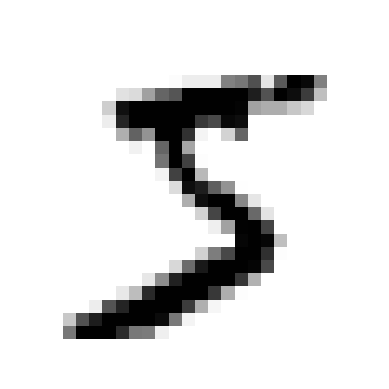

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [ ]:
y[0]

'5'

In [4]:
import numpy as np
y=y.astype(np.uint8)

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 이진 분류기 훈련
숫자 5만 식별한다고 할 때 5-감지와 5가 아님 으로 2개의 클래스를 구분할 수 있는 이진 분류기.

In [7]:
y_train_5 = (y_train==5) # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test==5)

확률적 경사 하강법 분류기: SGDClassifier 클래스 이용. 매우 큰 데이터 셋을 효율적으로 처리. 한 번에 하나씩 훈련 샘플을 독립적으로 처리.

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([some_digit])

array([ True])

## 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 측정

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


StratifiedKFold는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링 수행. 매 반복에서 분류기 객체를 복제해 훈련 폴드로 훈련시키고 테스트 폴드로 예측 만듦. 올바른 예측 수를 세어 정확한 예측의 비율 출력

In [10]:
# cross_val_score() 함수로 폴드가 3개인 K겹 교차 검증을 사용해 SGDClassifier모델 평가
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [11]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

불균형 데이터셋을 다룰 때 정확도를 분류기의 성능 측정 지표로 선호하지 않는다

### 3.3.2 오차 행렬
클래스 1의 샘플이 2로 분류된 횟수를 세는 것.

In [12]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

오차 행렬의 행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타냄.

In [14]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

양성 예측의 정확도: 정밀도 = tp/(tp+fp)
- 재현율과 같이 사용하는 것이 일반적. 재현율=tp/(tp+fn)
- 재현율 = 민감도 = 진짜 양성 비율

### 3.3.3 정밀도와 재현율

In [15]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

F1 점수 = 정밀도와 재현율의 조화 평균

In [16]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높음. 정밀도를 올리면 재현율이 줄고 재현율을 높이면 정밀도가 줄음. 정밀도/재현율 트레이드오프

### 3.3.4 정밀도/재현율 트레이드오프
SGDClassifier 분류기는 결정함수를 통해 각 샘플의 점수를 계산한다. 그 점수가 결정 임계값보다 크면 샘플을 양성 클래스에 할당하고 그렇지 않으면 음성 클래스에 할당.

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
threshold=0
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([ True])

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [20]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

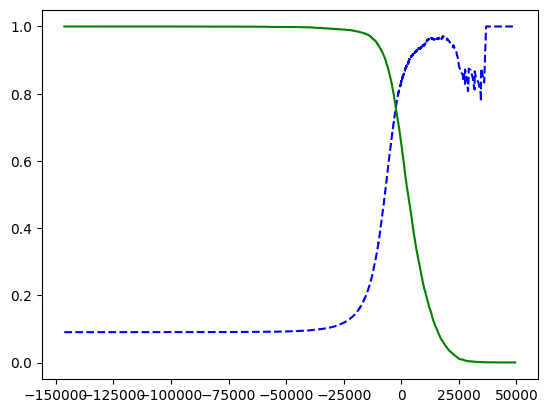

In [21]:
def plot_precision_recall_vs_threshold(precisions, recalls,thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
  plt.plot(thresholds, recalls[:-1], "g-", label="재현율")
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

정밀도 곡선이 더 울퉁불퉁하다. 좋은 정밀도/재현율 트레이드 오프를 선택하는 방법은 재현율에 대한 정밀도 곡선을 그리는 것이다.

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]

In [ ]:
y_train_pred_90 = (y_scores>=threshold_90_precision)

In [ ]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### 3.3.5 ROC 곡선
수신기 조작 특성 곡선은 정밀도에 대한 재현율 곡선이 아니고 거짓 양성 비율에 대한 진짜 양성 비율의 곡선. 민감도에 대한 1-특이도 그래프

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

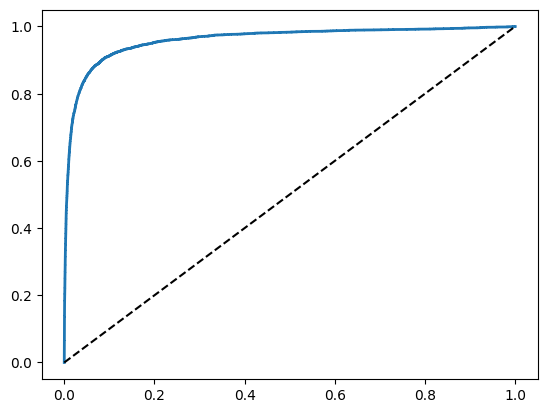

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1],[0,1],'k--')
plot_roc_curve(fpr, tpr)
plt.show()

재현율이 높을수록 분류기가 만드는 거짓 양성이 늘어남. 점선은 완전한 랜덤 분류기의 ROC 곡선을 뜻함. 좋은 분류기는 점선에서 최대한 멀리 떨어져 있어야 함. 곡선 아래의 면적을 측정하면 분류기 비교 가능. 완전한 분류기는 ROC의 AUC가 1이고 완전한 랜덤 분류기는 0.5이다.

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:,1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

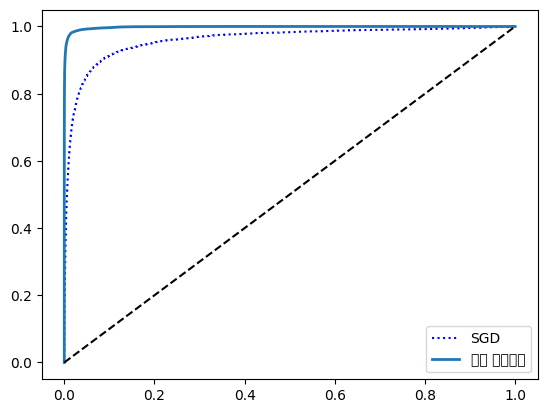

In [ ]:
plt.plot(fpr, tpr, "b:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right")
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

RandomForestClassifier의 ROC곡선이 왼쪽 위 모서리에 더 가까워 SGDClassifier보다 훨씬 좋음.

## 3.4 다중 분류
다중 분류기는 둘 이상의 클래스 구별 가능. 클래스가 10개인 숫자 이미지 분류 시스템을 만들 수 있다. 이미지를 분류할 때 각 분류기의 결정 점수 중 가장 높은 것을 클래스로 선택. 이를 OvR 전략이라 함. 0과 1 구별 0과2 구별 등 각 숫자 조합마다 이진 분류기 훈류시키는 방법 OvO 전략. 클래스가 N개라면 분류기는 Nx(N-1)/2개 필요.

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

y_train_5 대신 원래 타깃 클래스를 사용해 SVC 훈련 후 예측 수행

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [ ]:
np.argmax(some_digit_scores)

5

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
svm_clf.classes_[5]

5

사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier 사용.

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있어 별도로 OvR OvO적용 필요 없음

In [ ]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 3.5 에러 분석
GridSearchCV를 사용해 하이퍼 파라미터 튜닝.

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

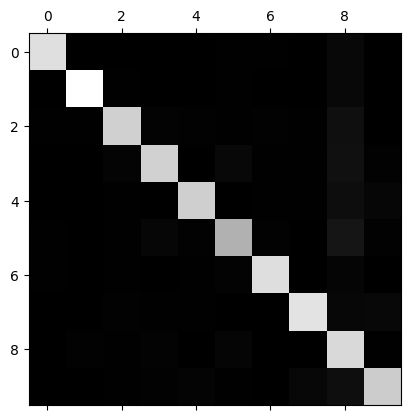

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

오차 행렬은 대부분의 이미지가 올바르게 분류됨을 나타내는 주대각선에 있어 매우 좋음.

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

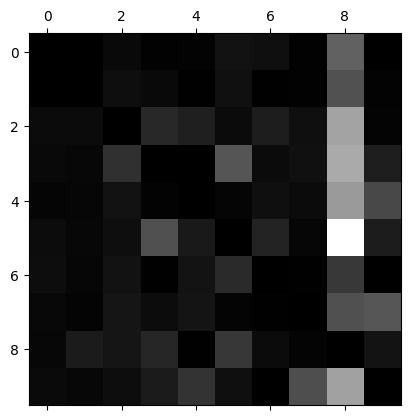

In [ ]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

행은 실제 클래스, 열은 예측한 클래스. 많은 이미지가 8로 잘못 분류됨.

In [26]:
cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [24]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(221)
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222)
plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223)
plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224)
plot_digits(X_bb[:25], images_per_row=5)
plt.show()

integer division or modulo by zero <- plot_digits 오류

대부분의 잘못 분류된 이미지는 확실히 에러인 것 같고 분류기가 실수한 이유를 이해하기 어려움. 원인은 선형 모델인 SGDClassifier를 사용했기 때문. 선형 분류기는 클래스마다 픽셀에 가중치 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스 점수로 계산. 3과 5는 몇 개의 픽셀만 달라 모델이 쉽게 혼동

## 3.6 다중 레이블 분류
분류기가 샘플마다 여러 개의 클래스를 출력해야 할 때도 있음. 여러 개의 이진 꼬리표를 출력하는 분류 시스템을 다중 레이블 분류 시스템이라고 함.

In [29]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >=7)
y_train_odd = (y_train%2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

각 숫자 이미지에 2개의 타깃 레이블이 담긴 y_multilabel 배열을 만듦. 숫자가 큰 값인지, 홀수인지.

In [30]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [31]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

각 레이블의 F1 점수를 구하고 평균 점수 계산. 모든 레이블의 가중치가 같다고 가정. 레이블에 클래스의 지지도를 가중치로 줌 그러면 average="weighted"로 하면 됨

## 3.7 다중 출력 분류
다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화. 이미지에서 잡음 제거 시스템. 넘파이의 randint() 함수를 사용해 픽셀 강도에 잡음 추가

In [32]:
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train+noise
noise = np.random.randint(0,100,(len(X_test), 784))
X_test_mod = X_test +noise
y_train_mod = X_train
y_test_mode = X_test

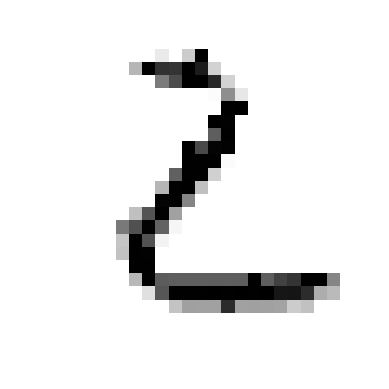

In [35]:
some_index=1
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digits(clean_digit)

분류기를 훈련시켜 이미지를 깨끗하게 만듦.